# The ARMA framework, part 3: Forecasting

We will show how to use ARMA estimation results to build forecasts and prediction intervals, both with the built-in statsmodels methods and by hand, focusing on the example of trying to forecast the quarterly (seasonally adjusted) GDP growth rate.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import math
import numpy as np
from numpy.random import normal

from matplotlib import pyplot as plt

import wrds
import fredapi

from scipy.optimize import minimize

from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LB

import os
from dotenv import load_dotenv
load_dotenv();

## Forecasting GDP growth rate in the ARMA framework

Let's resume the example from last time: Download and plot quarterly GDP growth from 1980 to 2010.

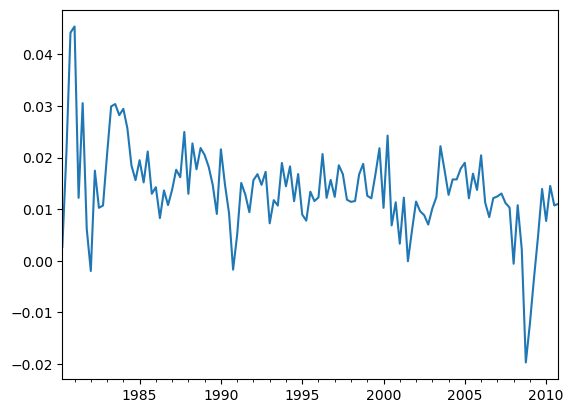

In [2]:
GDP = fredapi.Fred().get_series('GDP'  , observation_start = '1980-01-01', observation_end = '2010-12-31', frequency='q', aggregation_method = 'sum').resample('Q').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP_growth = np.log(GDP).diff().dropna()
GDP_growth.plot();

We already decided that an AR(1) model is reasonable for this process, so let's estimate that model.

In [3]:
GDP_growth_AR1_results = ARIMA(GDP_growth,order=(1,0,0)).fit()

Take a look at the model results, and plot the model's fitted values against the data.

In [4]:
print( GDP_growth_AR1_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 432.518
Date:                Thu, 01 Jan 2026   AIC                           -859.037
Time:                        14:24:52   BIC                           -850.600
Sample:                    06-30-1980   HQIC                          -855.610
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.001     10.102      0.000       0.011       0.016
ar.L1          0.5234      0.052     10.054      0.000       0.421       0.625
sigma2      5.146e-05   4.51e-06     11.413      0.0

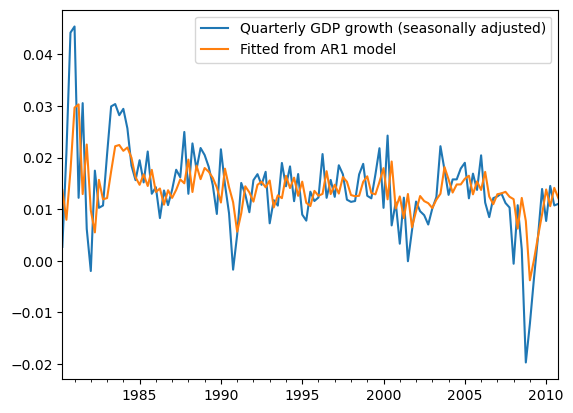

In [5]:
GDP_growth.plot(legend=True,label="Quarterly GDP growth (seasonally adjusted)");
GDP_growth_AR1_results.fittedvalues.plot(legend=True,label="Fitted from AR1 model");

Now let's build forecasts following the approach described in the slides.

**Automated forecasts through statsmodels:**

The results object that was returned by the ARIMA().fit() command includes tools for forecasting, so let's first see how to use those.

To just get a list of forecasts, we can use the forecast() function with the desired number of observations (quarters). This returns a list of forecasts beyond the end of the training data, conveniently indexed with the corresponding dates. (The exponential smoothing tools had a similar setup.)

In [6]:
GDP_growth_forecasts = GDP_growth_AR1_results.forecast(16)
display(GDP_growth_forecasts)

2011-03-31    0.012307
2011-06-30    0.012977
2011-09-30    0.013328
2011-12-31    0.013512
2012-03-31    0.013608
2012-06-30    0.013658
2012-09-30    0.013685
2012-12-31    0.013699
2013-03-31    0.013706
2013-06-30    0.013710
2013-09-30    0.013712
2013-12-31    0.013713
2014-03-31    0.013713
2014-06-30    0.013713
2014-09-30    0.013714
2014-12-31    0.013714
Freq: QE-DEC, Name: predicted_mean, dtype: float64

To compare this with reality, let's download the data on GDP growth beyond the end of our current window, and plot this alongside the forecasts:

In [7]:
GDP_future = fredapi.Fred().get_series('GDP'  , observation_start = '2010-12-31', observation_end = '2014-12-31', frequency='q', aggregation_method = 'sum').resample('Q').first()
GDP_future = GDP_future / 1000
GDP_future = GDP_future / 4
GDP_growth_future = np.log(GDP_future).diff().dropna()

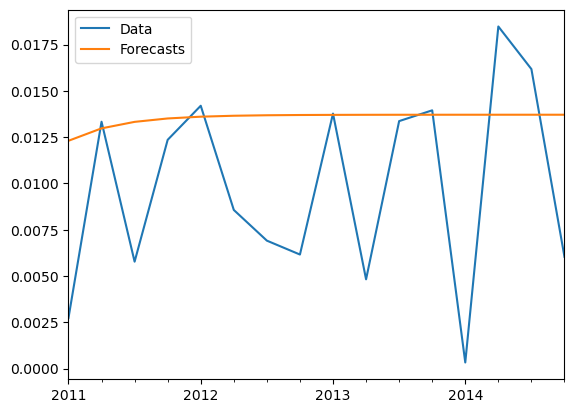

In [8]:
GDP_growth_future.plot(legend=True,label="Data");
GDP_growth_forecasts.plot(legend=True,label="Forecasts");

In practice we often want a prediction *interval* around the point forecasts above. To plot this, we will switch from the forecast() method to the get_forecast() method. Although they have similar names, the latter gives us much more information, including what we need to build prediction intervals. 

The get_forecast() method actually returns a large object that is more than we need. A convenient next step is to use in turn the summary_frame() method that it returns, which gives us a nicely organized dataframe. 

In [9]:
forecasts_frame = GDP_growth_AR1_results.get_forecast(16).summary_frame()
display(forecasts_frame)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2011-03-31,0.012307,0.007174,-0.001753,0.026367
2011-06-30,0.012977,0.008097,-0.002893,0.028847
2011-09-30,0.013328,0.008332,-0.003002,0.029659
2011-12-31,0.013512,0.008395,-0.002943,0.029967
2012-03-31,0.013608,0.008413,-0.002880,0.030097
2012-06-30,0.013658,0.008417,-0.002839,0.030156
2012-09-30,0.013685,0.008419,-0.002815,0.030185
2012-12-31,0.013699,0.008419,-0.002802,0.030200
2013-03-31,0.013706,0.008419,-0.002795,0.030207
2013-06-30,0.013710,0.008419,-0.002792,0.030211


In this frame, you can see that the forecasts from before are now stored in the "mean" column, and there are also new columns that we can use to build prediction intervals. The column "mean_se" is a standard error can be added or subtracted from the mean as many times as we want, to get a specific prediction interval. 

For convenience, the code already does one example for us: The columns "mean_ci_lower" and "mean_ci_upper" are a 95% confidence interval around the "mean" value (from adding and subtracting roughly two times "mean_se"). So we could just plot those along with "mean".

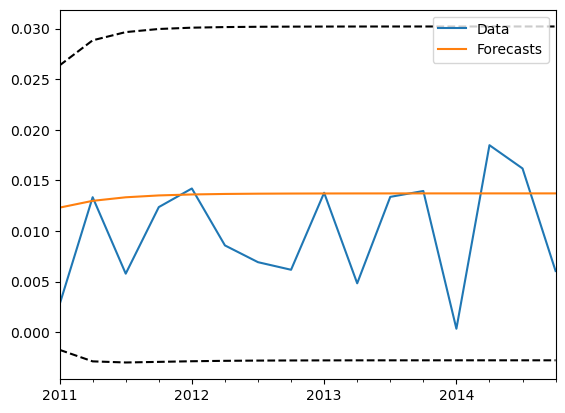

In [10]:
GDP_growth_future.plot(legend=True,label="Data");
forecasts_frame['mean'].plot(legend=True,label="Forecasts");
forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

**RMSE**

Finally, we can assess the accuracy of the forecasts out-of-sample with a few different methods. One popular statistic for this is called RMSE (root mean-squared-error). This gives a sense of how accurate the typical forecast is beyond the end of the data. 

We first calculate the error in each month after the end of the data, as the true value minus the forecast. Then we square each of these errors, and take the average of those squared values. Finally, we take the square root of that number to put things back on the same scale as the original errors. See calculations below.

In this case the RMSE of the forecasts is 0.0062. This does not tell us much on its own. But if we have more than one forecasting model under consideration, then we can calculate the RMSE of each one and use it to compare their out-of-sample performance. Obviously a lower number is better.

In [11]:
forecast_errors = GDP_growth_future - forecasts_frame['mean']
squared_forecast_errors = forecast_errors**2
mean_squared_forecast_error = squared_forecast_errors.mean()
RMSE = np.sqrt(mean_squared_forecast_error)
print("RMSE = " + '%5.4f' % RMSE)

RMSE = 0.0062


**Match the forecasts by hand:**

Obviously, the statsmodels tools are the most convenient way to build forecasts. But let's show what they are doing behind the scenes, both so that we understand better, and so that we would be able to figure out how to get the same results from other software.

We fit an AR(1) model, which looks like 
$$
y_t = \mu + \phi y_{t-1} + u_t \quad\quad u_t \sim \mathscr{N}(0,\sigma^2)
$$
The standard approach to building forecasts is to act as though, after fitting the model, all the model parameters ($\mu$, $\phi$, $\sigma^2$) are actually known, and so are the error terms ($u_t$) up through the last time for which we have data. In reality we only have estimates of these numbers from when we fit the model, so there is really more error in the prediction than what this approach measures, but it is standard to ignore this extra issue.

Use the letter $T$ to label the last observation in the dataset that we used to train the model. (In this example $T$ is December 2010.) If we think we actually know all the values of $\mu$, $\phi$, and $u_t$ through $T$, then the best forecast of $y_{T+1}$ is $\mu + \phi y_T$. 

(What we mean precisely by "best" forecast is that it has smaller squared prediction error than any other forecast.
To derive this best forecast formally, take the expectation of both sides, conditional on the information available at $T$, and note that $\mathbb{E}_T[u_{T+1}] = 0$.)

Let's calculate this forecast by hand and compare with the output from statsmodels.
Before we can do this, we have to add one more minor detail. The software actually fits a model for $y_t - \mu$, which is called a "recentered" version of the original AR(1) process. It looks like this:
$$
y_t - \mu = \phi (y_{t-1} - \mu) + u_t
$$
This change makes the model slightly better behaved, and it doesn't affect the estimate that you get for $\phi$, but it does very slightly affect the forecasts. In order to make things match exactly, we will predict each $y_t$ as $\mu + \phi(y_{t-1} - \mu)$ following this modified model. So our best forecast of $y_{T+1}$ is $\mu + \phi(y_T - \mu)$.

To calculate the forecasts, first save the parameters from our earlier estimation:

In [12]:
mu,phi,sigma2 = GDP_growth_AR1_results.params

Then apply the above formula:

In [13]:
GDP_growth_forecast_manual_1 = mu + phi*(GDP_growth.iloc[-1] - mu)
print("Forecast for 2011Q1 by hand: " + '%7.6f' % GDP_growth_forecast_manual_1 )
print("Compare with statsmodels output: " + '%7.6f' % GDP_growth_forecasts['2011Q1'] )

Forecast for 2011Q1 by hand: 0.012307
Compare with statsmodels output: 0.012307


Next, what's our *two*-step-ahead forecast best forecast, i.e. our best for $T+2$ as of time $T$? 
If we knew $y_{T+1}$ we would calculate this forecast as $\mu + \phi(y_{T+1} - \mu)$. We don't know $y_{T+1}$, but we can just substitute in our best forecast of it that we just calculated:

In [14]:
GDP_growth_forecast_manual_2 = mu + phi*(GDP_growth_forecast_manual_1 - mu)
print("Forecast for 2011Q2 by hand: " + '%7.6f' % GDP_growth_forecast_manual_2 )
print("Compare with statsmodels output: " + '%7.6f' % GDP_growth_forecasts['2011Q2'] )

Forecast for 2011Q2 by hand: 0.012977
Compare with statsmodels output: 0.012977


And we could continue substituting in like this as far out as we want to go.

Next, where do the prediction intervals come from? 

Start with our first forecast for $y_{T+1}$. Write out $y_{T+1} = \mu + \phi y_T + u_{T+1}$. The only unknown component here is $u_{T+1}$. The variance of $y_{T+1}$ around our prediction of $\mu + \phi y_T$ will be equal to the variance of $u$, which we labeled $\sigma^2$ and estimated as part of our model. The standard error of our forecast is then $\sqrt{ \hat{\sigma}^2 }$, where $\hat{\sigma}^2$ is the estimate that we got from fitting the model.

In [15]:
GDP_growth_SE_manual_1 = math.sqrt( sigma2 )
print("Standard error of 2011Q1 forecast by hand: " + '%7.6f' % GDP_growth_SE_manual_1 )
print("Compare with statsmodels output: " + '%7.6f' % forecasts_frame['mean_se']['2011Q1'] )

Standard error of 2011Q1 forecast by hand: 0.007174
Compare with statsmodels output: 0.007174


To match the 95% confidence interval from statsmodels, we just add and subtract roughly 2 standard deviations above and below our forecast.

In [16]:
exact_t = 1.95996398454005423552

GDP_growth_CI_lower_1 = GDP_growth_forecast_manual_1 - exact_t*GDP_growth_SE_manual_1
GDP_growth_CI_upper_1 = GDP_growth_forecast_manual_1 + exact_t*GDP_growth_SE_manual_1

print("95% confidence interval for our 2011Q1 forecast is (" 
      + '%7.6f' % GDP_growth_CI_lower_1
      + " , " 
      + '%7.6f' % GDP_growth_CI_upper_1
      + ")")

print("Compare with statsmodels: (" 
      + '%7.6f' % forecasts_frame['mean_ci_lower']['2011Q1']
      + " , " 
      + '%7.6f' % forecasts_frame['mean_ci_upper']['2011Q1']
      + ")")

95% confidence interval for our 2011Q1 forecast is (-0.001753 , 0.026367)
Compare with statsmodels: (-0.001753 , 0.026367)


Finally, what about the prediction intervals of our forecasts beyond $T+1$? The slides from class show some formulas based on substituting in recursively the variance of each future forecast up to the forecast date.

Another way to get the same formulas is to convert the process to an MA form (which we can always do from the Wold theorem). In the MA form of an AR(1) process, the MA coefficient at each lag $k$ is $\phi^k$. 

Now think about forecasting $y_{T+2}$ as of time $T$. Use the MA form described above to write out:
$$
y_{T+2} = \mu + u_{T+2} + \phi u_{T+1} + \phi^2 u_{T} + \phi^3 u_{T-1} ...
$$
As of time $T$, the only things you don't know yet are $u_{T+1}$ and $u_{T+2}$. The variance of your forecast of $y_{T+2}$ is equal to
$$
Var(u_{T+2} + \phi u_{T+1}) = Var(u_{T+2}) + Var(\phi u_{T+1}) = Var(u_{T+2}) + \phi^2 Var(u_{T+1}) = \sigma^2 \times (1 + \phi^2)
$$
Similarly we can write out $y_{T+3}$ and see that the variance of our forecast as of time $T$ will be the variance of $u_{T+3} + \phi u_{T+2} + \phi^2 u_{T+1}$, which works out to $\sigma^2\times(1 + \phi^2 + \phi^4)$. As our forecast horizon gets longer and longer, these variances limit to the unconditional variance of $y$ which is $\frac{\sigma^2}{1-\phi^2}$. 

For any particular horizon, we can use this pattern to figure out the variance of the forecast at that horizon, then take the square root to get a standard error, and add plus or minus two standard errors around the forecast to get a prediction interval.

In [17]:
GDP_growth_SE_manual_2 = math.sqrt( sigma2*(1+phi**2) )
print("Standard error of 2011Q2 forecast by hand: " + '%7.6f' % GDP_growth_SE_manual_2 )
print("Compare with statsmodels output: " + '%7.6f' % forecasts_frame['mean_se']['2011Q2'] )

Standard error of 2011Q2 forecast by hand: 0.008097
Compare with statsmodels output: 0.008097


In [18]:
GDP_growth_SE_manual_3 = math.sqrt( sigma2*(1+phi**2+phi**4) )
print("Standard error of 2011Q3 forecast by hand: " + '%7.6f' % GDP_growth_SE_manual_3 )
print("Compare with statsmodels output: " + '%7.6f' % forecasts_frame['mean_se']['2011Q3'] )

Standard error of 2011Q3 forecast by hand: 0.008332
Compare with statsmodels output: 0.008332


And so forth.

**One-step forecasts with refitting:**

Another way we could evaluate the AR(1) approach, perhaps closer to what you would do in practice (and also closer to how we evaluated the exponential smoothing approach): 
Imagine building one-step forecasts every quarter, then updating and refitting the model with that quarter's data before making another prediction.
Statsmodels also provides some very convenient tools for this, illustrated below.

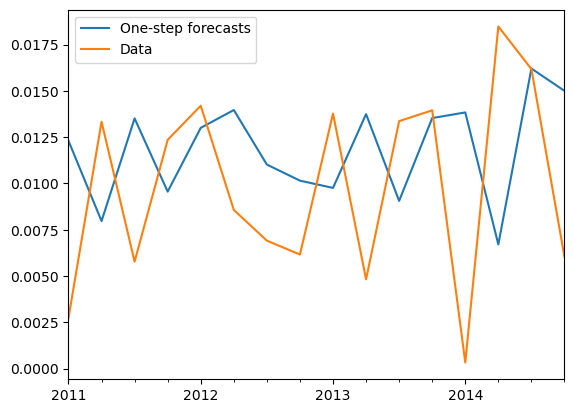

In [19]:
# Estimate the model just based on the data through 2010.
# These results will be identical to the ones we have been using so far.
GDP_growth_onestep_results = ARIMA(GDP_growth,order=(1,0,0),trend='c').fit()

# Make an initial forecast, one step beyond the end of the data.
onestep_forecasts = GDP_growth_onestep_results.forecast(1)

# Now start looping over all the dates after our training period, through the end of 2014.
# At each row, bring in one new datapoint of GDP, add it to the model, and predict the next observation.
for q in pd.date_range('2011Q1','2014Q4',freq='Q'):
    # Grab the next observation of GDP.
    # (The double brackets force Pandas to return a Dataframe, not just a number,
    # which is necessary for feeding that into the "append" method in the next step.)
    next_observation = GDP_growth_future.loc[[q]]
    # Add the new observation to the dataset using the "append" method that exists for this purpose.
    GDP_growth_onestep_results = GDP_growth_onestep_results.append( next_observation );
    # Make the next forecast: 
    # Now the model is refitted based on all the data including the observation we just added,
    # and the forecast will be for one date further in the future.
    next_forecast = GDP_growth_onestep_results.forecast()
    # Add that forecast to the end of the lists of forecasts we've already made.
    onestep_forecasts = pd.concat( [ onestep_forecasts , next_forecast ] );

onestep_forecasts.plot(legend=True,label="One-step forecasts")
GDP_growth_future.plot(legend=True,label="Data");